<a href="https://colab.research.google.com/github/MartinBruchon/MartinBruchon/blob/main/corrosion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
from lxml import etree
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
!unzip -q dataset.zip

In [3]:
def dirparser(path):
    path = Path(path)
    output = []
    for folders in os.listdir(path):
        for fname in os.listdir(path / folders):
            _, ext = fname.split('.')
            if ext in ['png', 'PNG', 'jpg', 'JPG', 'jpeg', 'JPEG']:
                img = Image.open(path / folders / fname).convert('RGB')
                output.append((np.array(img), folders))
    return output

In [4]:
train_set = dirparser("./dataset/train")
valid_set = dirparser("./dataset/valid")

(<matplotlib.image.AxesImage at 0x7f9d3b4ebdc0>, 'OK')

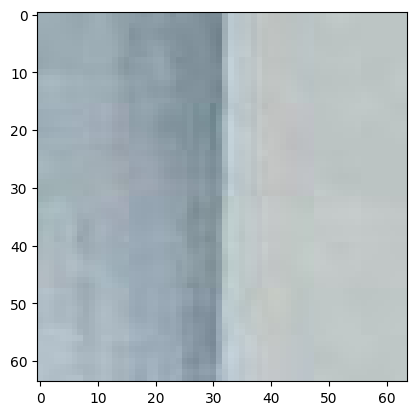

In [5]:
x, y = valid_set[1]
plt.imshow(x), y

In [6]:
val_idx = list(range(len(train_set), len(train_set) + len(valid_set)))

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = ItemGetter(0),
                   get_y = ItemGetter(1),
                   splitter=IndexSplitter(val_idx),
                   item_tfms=[Resize(64, method='squish')],
                   batch_tfms=[*aug_transforms(size=64, 
                                               max_rotate=20, 
                                               max_zoom=1.0,
                                               max_lighting=0.25), 
                               Normalize.from_stats(*imagenet_stats)])               


dls = dblock.dataloaders(train_set + valid_set, bs=2, shuffle_train=True)

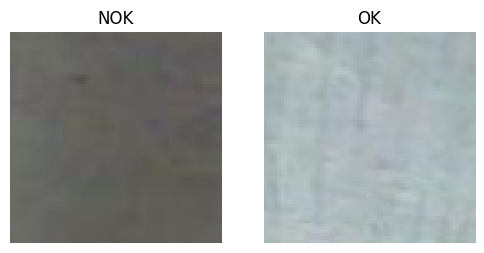

In [7]:
dls.train.show_batch()

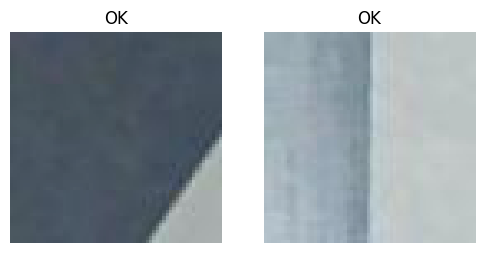

In [10]:
dls.valid.show_batch()

In [14]:
learn = cnn_learner(dls, resnet18, 
                    loss_func=CrossEntropyLossFlat(), 
                    metrics=accuracy)

In [ ]:
learn.lr_find()

In [15]:
learn.fine_tune(50, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.394099,1.392896,0.400000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,1.162267,0.792796,0.800000,00:01
1,1.373123,0.856932,0.400000,00:01
2,1.159186,1.433824,0.400000,00:01
3,1.222704,1.670946,0.400000,00:01
4,1.115415,1.787483,0.400000,00:01
5,1.133034,2.007861,0.400000,00:01
6,1.241399,0.395628,0.800000,00:02
7,1.153715,0.329493,0.800000,00:01
8,1.035286,0.548278,0.800000,00:01
9,1.158426,0.767506,0.400000,00:01


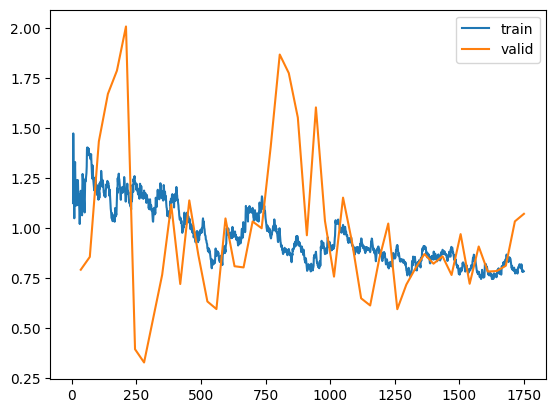

In [16]:
learn.recorder.plot_loss()

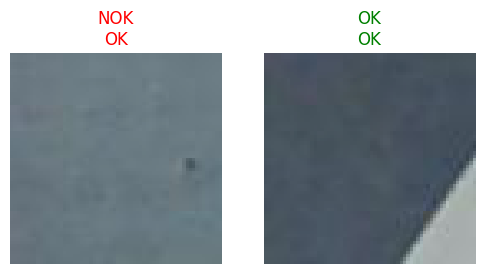

In [17]:
learn.show_results()

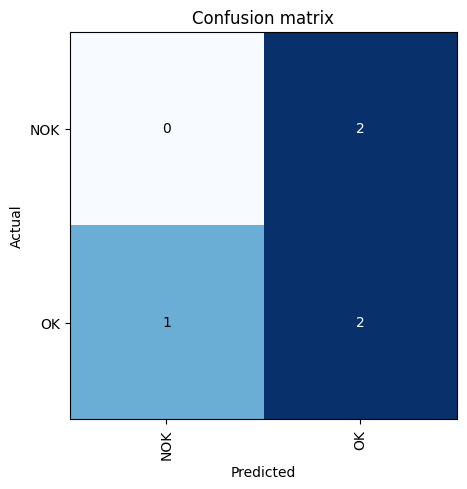

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

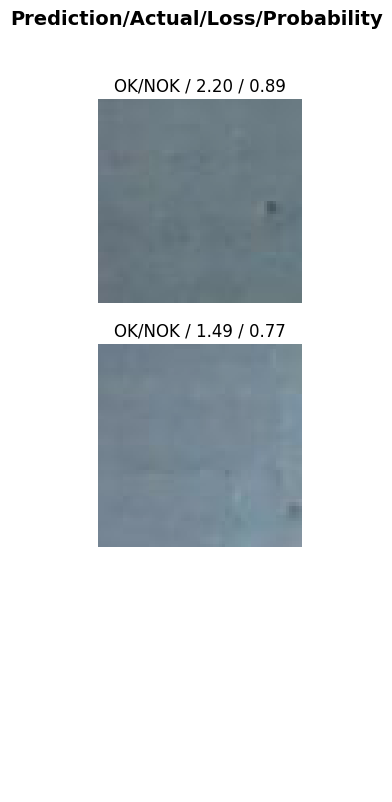

In [20]:
interp.plot_top_losses(2, nrows=3)

In [ ]:
learn.save('./test')